<h1 style="text-align:center;padding-top:50px"> <b>Topic Extraction with Knowledge Graphs</b></h1>
<h4 style="text-align:center">by Emanuel Gerber</h4>

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import FileLink, FileLinks

## Introduction

<b>Motivation</b>: Topic Extraction is about exploring a large text corpus and finding important topics in an unsupervised way. Popular methods in the domain, such as LDA or Kmeans typically work with "bag of words", simple representations of words in documents, that consider only the frequency of occurence of words, regardless of syntactical structure. Topic modeling models (in particular LDA) can infer topics in the underlying corpus by observing distributions of words across documents in the corpus. This requires large corpora, since words need occur across mulitple documents in order to detect distributional patterns between them.

This work is introducing a new approach for topic extraction that uses information from a knowledge graph for finding and extracting topics from a corpus. Knowledge graphs such as Wikidata contain a large base of real world entities. Wikidata in particular provides a taxonomical structure that allows to specify the category for each entity (e.g. banana -> fruit, Microsoft -> company). In this notebook I will explore ways to use categorical information in order to extract topics from a large text corpus. The goal is to show that knowledge graph can help to find more semantically meaningful topics.


<table><tr><td><img src="img/topic-modeling.webp" width="500px"/></td><td><img src="img/knowledge-graph.jpg" width="500px"/></td><td><img src="img/Google_Knowledge_Panel.png" style="align:center" width="400px"/></td></tr></table>

## Comparison of Knowledge Graphs
* Wikidata
* Dbpedia
* Yago
* ...
<table>
    <tr>
        <td><img src="img/wikidata-logo.png" width="200px"/></td>
        <td><img src="img/dbpedia-logo.svg" width="200px"/></td>
        <td><img src="img/yago-logo.png"/ width="200px"></td>
    </tr>
    </table>

<table>
    <tr>
        <th><h2>Ontology</h2></th>
        <th><h2>Taxonomy</h2></th>
    </tr>
    <tr>
        <td><img src="img/example-ontology.jpeg" width="400px"/></td>
        <td><img src="img/example-taxonomy.jpeg" width="400px"/>
    </tr>
    <tr>
        <td><h3>defines relationships between concepts, data and entities</h3></td>
        <td><h3>defines hierarchical classification</h3></td>
    </tr>
    </table>

# Wikidata 

###  Using Kensho Derived Wikimedia Dataset (https://www.kaggle.com/kenshoresearch/kensho-derived-wikimedia-data)
* page.csv (page_id, item_id, title, views)
* item.csv (item_id, en_label, en_description)
* alias.csv (item_id, en_alias)
* statements.csv (source_item_id, edge_property_id, source_item_id)

<table><tr><td><img src="img/kensho-logo" width="400px"/></td></tr></table>

<table><tr><td><img width="800px" src="img/example-wikidata"/></td></tr></table>

## Wikidata is <b>huge</b>
* Cities
* Rivers
* Mountains
* Molecules
* Organs
* Instruments
* Stars
* Soccer Teams
* People
* Programming Languages
* Universities
* Plants
* .... (and much more)

It contains (basically) everything that has wikipedia article + provides structured information about it
=> Extremely powerful "labeled" dataset

<b>Examples:</b>
* https://www.wikidata.org/wiki/Q312 (Apple Inc.)
* https://www.wikidata.org/wiki/Q89 (apple)
* https://www.wikidata.org/wiki/Q2981 (Notre Dame)
* https://www.wikidata.org/wiki/Q664 (New Zealand)

# Knowledge Graph Preprocessing

The original knowledge graph from wikidata contains ~55 million entities and ~140 million statements
Most of them contain information such as 
* Molecules
* train stations
* chinese towns
* mountains
* scientific articles
* stars
* rivers
* ...

The original wikidata ontology very large and has disproportionally many items for highly specific types such as stars, proteins, etc., which have little practical use for general purpose topic extraction.
Therefore, we will reduce the original knowledge graph in the following step. We will only keep items that have a corresponding wikipedia page associated <b>OR</b> which represent higher level categories in the graph (those items that have an <code>in-degree>0</code> w.r.t to the properties <code>subclass_of</code> and <code>instance_of</code>)
Furthermore we can discard all statements that
* link to removed items
* have a property other than P31 (instance of) or P279 (subclass of)

Note: The input files for this section are >7gb and are not included in this repo. Only the filtered files for further processing are included

In [125]:
import pandas as pd
from tqdm import tqdm

In [126]:
#Load wikipedia page_items
df_pages=pd.read_csv("data/wikidata/pages.csv")
# Load (pre-generated) list of all entites with in-degree>0 for Properties P31 (instance_of) and P279 (subclass_of)
df_categories=pd.read_csv("data/wikidata/category_entites.csv",names=['id'])

In [127]:
category_entity_ids=df_categories["id"].tolist()
wikipedia_entity_ids=df_pages["item_id"].tolist()

filtered_entity_ids=category_entity_ids+wikipedia_entity_ids

In [ ]:
#Load all statements chunkwise and filter
chunksize = 2000000
NUM_STATEMENT_LINES=141206854
file_path="data/wikidata/statements.csv"

df_chunks = pd.read_csv(file_path, chunksize=chunksize)
df_statements = pd.DataFrame()

for df_chunk in tqdm(df_chunks, total=NUM_STATEMENT_LINES/chunksize, desc='filtering statements'):
    df_statements = df_statements.append(df_chunk[(df_chunk["source_item_id"].isin(filtered_entity_ids)) & df_chunk["edge_property_id"].isin([31,279])])

df_statements.to_csv('data/wikidata_filtered/statements.csv',index=False)

In [28]:
df_statements

,source_item_id,edge_property_id,target_item_id
0,1,31,36906466
1,1,279,3695190
37,2,31,3504248
95,3,31,937228
96,3,279,203872
...,...,...,...
140908389,76998317,279,476300
140917079,77004049,279,2385804
140959172,77016498,279,407142
140959173,77016498,279,574302


Now we perform the same filtering for entity aliases

In [130]:
df_aliases=pd.read_csv("data/wikidata/item_aliases.csv")
df_aliases[df_aliases["item_id"].isin(filtered_entity_ids)].to_csv("data/wikidata_filtered/aliases.csv",index=False)
df_aliases["en_alias_lower"]=df_aliases["en_alias"].str.lower()
df_aliases.head()

,item_id,en_alias,en_alias_lower
0,1,Our Universe,our universe
1,1,The Universe,the universe
2,1,The Cosmos,the cosmos
3,1,cosmos,cosmos
4,2,Blue Planet,blue planet


Finally we filter all entities

In [ ]:
df_entities=pd.DataFrame()
df_chunks=pd.read_csv("data/wikidata/item.csv",chunksize=chunksize)
for df_chunk in tqdm(df_chunks, total=55000000/chunksize, desc='filtering entities'):
    df_entities=df_entities.append(df_chunk[df_chunk["item_id"].isin(filtered_entity_ids)])

In the last step, we merge the entity information with page visits for from the corresponding wikipedia item. Combining these columns will be helpful for Entity linking the in the following steps.

In [132]:
df_joined=df_entities.merge(df_pages,how="outer",left_on="item_id",right_on="item_id")[["item_id","en_label","en_description","views"]]
df_joined.to_csv('data/wikidata_filtered/joined.csv',index=False)
df_joined.head()

,item_id,en_label,en_description,views
0,1,Universe,totality of space and all contents,37815.0
1,2,Earth,third planet from the Sun in the Solar System,163515.0
2,3,life,matter capable of extracting energy from the e...,21420.0
3,4,death,permanent cessation of vital functions,25512.0
4,5,human,"common name of Homo sapiens, unique extant spe...",60142.0


From now on, we will no longer work with DataFrames. Instead we will use a local sqlite database that was created with the preprocessed dataset. This has the advantage that the system can operate with more memory, because all datasets are retrieved from disk. Indices on all relevant table columns ensure that the retrieval of entities is reasonably fast. In addition, all queries are cached so that frequent entities can be taken from memory.

If you executed all the above commands, you should restart the kernel in order to clean up your memory. Afterwards just continue with the next sections

# Knowledge Graph Exploration

In this section, we analyse the distribution of entities by type in the wikidata knowledge graph. First we will show the most frequent categories, and then we will visualize a number of examples 

In [2]:
import pandas as pd
df_statements=pd.read_csv('data/wikidata_filtered/statements.csv')
df_joined=pd.read_csv('data/wikidata_filtered/joined.csv')

In [3]:
is_instance_counts = (
    df_statements.groupby(['target_item_id']).
    size().
    sort_values(ascending=False).
    to_frame().
    rename(columns={0: 'count'})
)

Most frequent types of entites:

In [4]:
is_instance_counts[:20].merge(df_joined,left_on="target_item_id",right_on="item_id")[["item_id","en_label","en_description","count"]]

,item_id,en_label,en_description,count
0,5,human,"common name of Homo sapiens, unique extant spe...",1653964
1,16521,taxon,"group of one or more organism(s), which a taxo...",315211
2,11424,film,sequence of images that give the impression of...,127768
3,486972,human settlement,"community of any size, in which people live",105712
4,482994,album,"collection of recorded music, words, sounds",105597
5,532,village,small clustered human settlement smaller than ...,78013
6,27020041,sports season,"season of a sports league or competition, gene...",75784
7,4830453,business,"organization involved in commercial, industria...",56131
8,134556,single,type of music release usually containing one o...,47884
9,101352,family name,"part of a naming scheme for individuals, used ...",45758


Less frequent entity types:

In [34]:
is_instance_counts[3000:3100].merge(df_joined,left_on="target_item_id",right_on="item_id")[["item_id","en_label","en_description","count"]]

,item_id,en_label,en_description,count
0,149086,homicide,killing of a human being by another human bein...,68
1,189290,military officer,member of an armed force or uniformed service ...,68
2,723916,turbojet,jet engine,68
3,23902005,literary festival,festival focused on literature,68
4,2613100,Jain temple,"the place of worship for Jains, the followers ...",68
...,...,...,...,...
95,163323,Roman legion,Roman military unit,65
96,63100595,Category 3 hurricane,tropical cyclone of Atlantic and east Pacific ...,65
97,1847301,municipalities of Sonora,Wikimedia list article,65
98,925381,city with powiat rights,administrative division of Poland,65


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def plot_instance_of(item_id,limit=30):
    graph = nx.DiGraph()

    filtered_statements=df_statements[df_statements["target_item_id"]==item_id][["source_item_id","target_item_id"]]
    
    graph.add_edges_from(filtered_statements[:limit].values)

    for node in graph.nodes:
        graph.nodes[node]["label"]=df_joined[df_joined["item_id"]==node]["en_label"].iloc[0]

    fig, ax = plt.subplots(figsize=(14,14))
    pos = nx.circular_layout(graph, scale=2.0)

    node_labels = nx.get_node_attributes(graph, 'label')
    pos = nx.spring_layout(graph, scale=2.0)
    ax= nx.draw_networkx_edges(graph,pos)
    ax2=nx.draw_networkx_nodes(graph,pos,node_size=800, node_color='red')
    ax3=nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight=500)

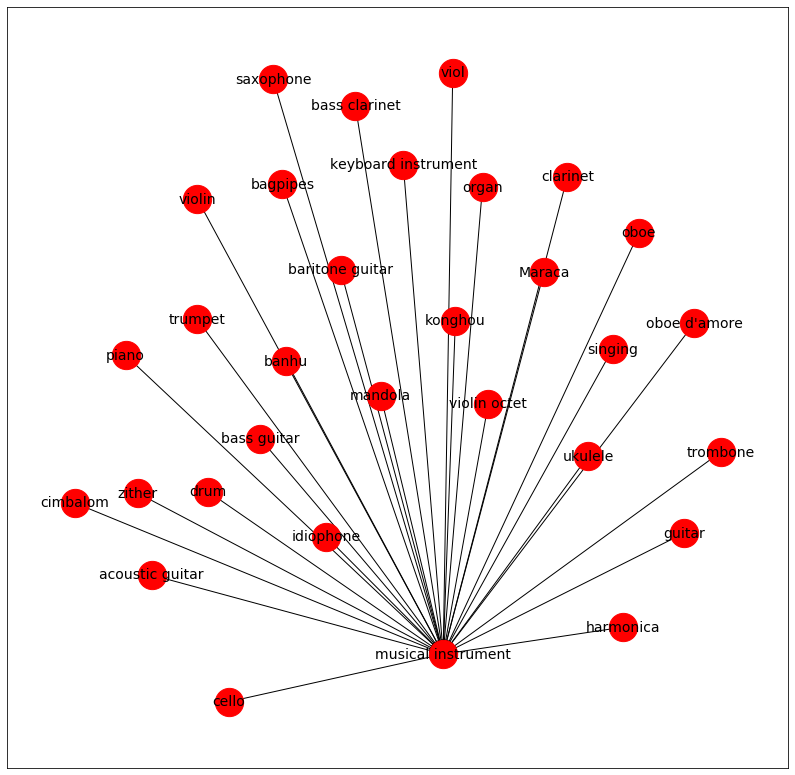

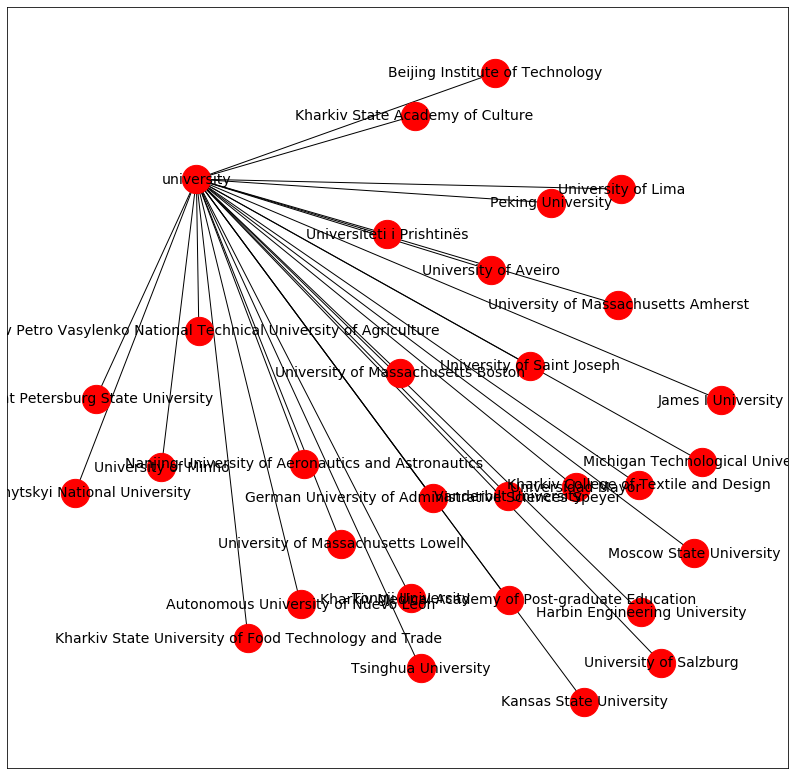

In [18]:
#plot_instance_of(5) #people
plot_instance_of(34379) #instruments
#plot_instance_of(6881511) #enterprises
#plot_instance_of(11173)#chemical compounds
#plot_instance_of(9415) #emotions
#plot_instance_of(11424) #film
#plot_instance_of(17412622) #car brands
plot_instance_of(3918) #universities
#plot_instance_of(431289) #brand

# Entity Linking (https://www.wikidata.org/wiki/Q17012245)

<b>Definition</b>: Entity linking [...] is the task of assigning a unique identity to entities (such as famous individuals, locations, or companies) that are  mentioned in text (wikipedia)


- e.g. given the text: "Steve Jobs and Bill Gates ate ice cream near the Golden Gate Bridge" we want to extract all terms that have a corresponding entity in the knowledge graph [<a href="https://www.wikidata.org/wiki/Q19837">Steve Jobs (Q19837)</a>, <a href="https://www.wikidata.org/wiki/Q13233">ice cream (Q13233)</a>, <a href="https://www.wikidata.org/wiki/Q5284">Bill Gates (Q5284)</a>, <a href="https://www.wikidata.org/wiki/Q44440">Golden Gate Bridge (Q44440)</a>]

<b>Entity Linking is a very difficult task due to amiguity</b>
* Apple (company vs fruit)
* Paris (city in France vs Paris Hilton)
* Python (programing language vs venemous snake)
* ...

## Approach

<img src="img/entity_linking_pipeline.svg"/>

## Term Variations

In order to find entities in our text, we must first extract all possible terms that may have a corresponding entitiy. Since all entities in wikidata are nouns, we limit ourself to nouns. Since most entities are composites of multiple words, we have to check for consecutive words. Also whole prepositional phrases (e.g. "Pirates of the Caribean") can be resolved to entities. So they need to be included as well.
The selection of term candidates out of documents is performed by analysing the <b>dependency graph</b>.

General rules are:
* observe subjects and objects in each sentence
* exlcude pronouns
* traverse graph trough coordinations ( x and y and z and ...)
* traverse graph through adverbials/prepositional phrases
* traverse relative clauses
* for every found term in plural, add singular form
* ...

In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.EntityLinker.EntityElement import EntityElement
from src.EntityLinker.EntityLinker import EntityLinker
from src.EntityLinker.TermCandidateExtractor import TermCandidateExtractor
from src.EntityLinker.Utils import *
import spacy
from spacy import displacy

nlp_cached=None
def  get_entity_linker_pipeline():
    global nlp_cached
    
    init_database_connection()
    if nlp_cached:
        return nlp_cached
    
    nlp=spacy.load('en_core_web_md')
    entityLinker=EntityLinker()
    nlp.add_pipe(entityLinker,last=True)
    nlp.disable_pipes("ner")
    
    nlp_cached=nlp
    
    return nlp

In [12]:
init_database_connection()

text1="I watched the Pirates of the Caribbean last silvester"
text2="The Golden Gate Bridge is located in San Francisco and attracts many chinese visitors every year"
text3="""This jupyter notebook is about topic extraction and knowledge graphs. 
        It performs entity linking based on wikidata items. The main technologies are python, pandas, scikit-learn, and spacy"""

nlp = get_entity_linker_pipeline()
doc1=nlp(text1)
doc2=nlp(text2)
doc3=nlp(text3)

displacy.render(doc1, style="dep",options={"compact":True})

Code Reference: <a href='src/EntityLinker/TermCandidateExtractor.py'>TermCandidateExtractor.py</a>
<br>
Code Reference: <a href='src/EntityLinker/TermCandidate.py'>TermCandidate.py</a>

In [90]:
for doc,text in zip([doc1,doc2,doc3],[text1,text2,text3]):
    print("\nINPUT TEXT '{}'\n".format(text))
    tce=TermCandidateExtractor(doc)
    for e in tce:
        e.pretty_print()


INPUT TEXT 'I watched the Pirates of the Caribbean last silvester'

Term Candidates are [Pirates, Pirates of the Caribbean]
Term Candidates are [silvester, last silvester]

INPUT TEXT 'The Golden Gate Bridge is located in San Francisco and attracts many chinese visitors every year'

Term Candidates are [Bridge, Golden Gate Bridge, Golden]
Term Candidates are [Francisco, San Francisco, San]
Term Candidates are [visitors, many chinese visitors, chinese visitors]
Term Candidates are [year]

INPUT TEXT 'This jupyter notebook is about topic extraction and knowledge graphs. 
        It performs entity linking based on wikidata items. The main technologies are python, pandas, scikit-learn, and spacy'

Term Candidates are [notebook, jupyter notebook, jupyter]
Term Candidates are [extraction, topic extraction, topic]
Term Candidates are [graphs, knowledge graphs, knowledge]
Term Candidates are [entity]
Term Candidates are [items, wikidata items, wikidata]
Term Candidates are [technologies, mai

## Entity Candidate Resolution

Now, every such "term candidate" needs to be resolved with entites from the knowledge graph. This resolving is done by transforming each term candidate to a lowercase representation and then matching it with all registered aliases from wikidata. 
Every term candidate can be therefore matched with a number of different entity candidates

So in summary, every noun in the sentence can be mapped to multiple variations of that noun
and every such term variation again can be mapped to multiple possible entity candidates

Code Reference: <a href="src/EntityLinker/EntityCandidates.py">EntityCandidates.py</a>
<br>
Code Reference: <a href="src/EntityLinker/EntityElement.py">EntityElement.py</a>
<br>
Code Reference: <a href="src/EntityLinker/EntityCollection.py">EntityCollection.py</a>

Ultimately, a classifier needs to decide which entity should be picked for the various possibilities of a term

In [17]:
tce=TermCandidateExtractor(doc3)
for e in tce:
    print("Entity candidates for [{}]:".format(e))
    print()
    e.get_entity_candidates().pretty_print()
    print("-----")

Entity candidates for [notebook, jupyter notebook, jupyter]:

https://www.wikidata.org/wiki/Q223374     223374     The Notebook                    2004 romantic drama film by Nick Cassavetes                                                         
https://www.wikidata.org/wiki/Q15106179   15106179   The Notebook                    2013 film directed by János Szász                                                                   
https://www.wikidata.org/wiki/Q43013      43013      notebook                        book for writing, drawing, scrapbooking                                                             
https://www.wikidata.org/wiki/Q7062555    7062555    Notebook                        2006 film by Rosshan Andrrews                                                                       
https://www.wikidata.org/wiki/Q16885223   16885223   Notebook                        2013 Nepali romance film directed by Yogesh Ghimire                                                 
https://

For each group of entities, one entity is classified by the classifier. The classification is performed based on the following heuristic

1. Select the entity that was matched with the most specific term (e.g. "Morgan J. Freeman" is more specific than "Morgan")
2. For all remaining entities, choose the entitiy whose casing is most specific with the spelling of the matched entity alias (e.g. If the expression was "...was introduced by [Apple] in ..." an the alternatives are "apple" (fruit) or "Apple" (company), choose Apple, the company, because it's spelling matches more closesly with the expression)
3. For all remaining entities,choose the entitiy with the highest prior (the most popular in terms of visits per month of the corresponding wikipedia page) - e.g. pick "Declaration of Independence" (12401 page views) over "2015 Turkish film directed by Mehmet Eryilmaz" (10 page views)


Note: This heuristic cannot guarantee 100% accuracy, as we will se in the following sections. There are more sophisticated approaches that take the embedding of the item description in combination with the embedding of the surrounding text in the original document in order to make a classification. Other approaches (https://drive.google.com/file/d/1EuGxcQLcXvjjkZ-KRUlwpr_doBVyEBEG/view) have shown, that the max prior method results in an accuracy of 78.2% wherease embedding methods achieve 84.2%.
However, these approaches require an extensive training time and are less flexible to updating entities in the knowledge graph. So the "max-prior" heuristic will be sufficient for this approach.
In general, entity linking remains an open research topic

### Entity Linking Results

In [92]:
doc1._.linkedEntities.pretty_print()
print("----")
doc2._.linkedEntities.pretty_print()
print("---")
doc3._.linkedEntities.pretty_print()

https://www.wikidata.org/wiki/Q194318     194318     Pirates of the Caribbean        Series of fantasy adventure films                                                                   
https://www.wikidata.org/wiki/Q12525597   12525597   Silvester                       the day celebrated on 31 December (Roman Catholic Church) or 2 January (Eastern Orthodox Churches)  
----
https://www.wikidata.org/wiki/Q44440      44440      Golden Gate Bridge              suspension bridge on the San Francisco Bay                                                          
https://www.wikidata.org/wiki/Q62         62         San Francisco                   consolidated city-county in California, United States                                               
https://www.wikidata.org/wiki/Q830719     830719     visitor pattern                 design pattern                                                                                      
https://www.wikidata.org/wiki/Q577        577        year        

## Entity Linker - Performance

In the next step, we can test the performance of the Entity Linker. For that reason, we extract all anchor links (blue links) from wikipedia. Every such link references a particular wikipedia page. Every such page contains an internal wiki page_id, which is again linked to a wikidata id. The following code iterates over all extracted anchor links and performs Entity linking on them. It counts the number of links that were correctly linked to the correct wikidata item and the number of wrong predictions.
Note that this measure in just an approximation of how well the Entity linker is working. Wikipedia pages generally only link items that are relevant to the current topic. For example, the terms "Philadelphia","Pennsylvania", "July 4,1776", "war", "Great Britain", etc. are not highlighted, even though there are wikipedia custom articles about them. Therefore the following score is biased towards encyclopedic items.

<img width="600px" src="img/wikipedia-anchors.png"/>

In [16]:
import pandas as pd
from src.EntityLinker.TermVariations import *
from src.EntityLinker.EntityClassifier import *
import time
from tqdm import tqdm
import spacy
init_database_connection()

df_anchors=pd.read_csv('data/anchor_links_merged.csv').dropna()

In [6]:
df_anchors

,anchor_text,item_id,anchor_target_count
0,United States,30,144375
1,American,30,68713
2,USA,30,8359
3,U.S.,30,7322
4,US,30,5193
...,...,...,...
12094719,Freedom of the Press Act,2456773,1
12094720,Darmois-Skitovich theorem,56375780,1
12094721,Australia–Iran relations,864614,1
12094722,Ja må han leva,2256415,1


Explanation: <b>anchor_text</b> refers to the text of the link, <b>item_id</b> references the associated wikidata item behind the target page, and <b>anchor_target_count</b> specifies the number of times the anchor_text links to the particular target_range. As we can see, the most requent anchor link is "United States" (Wikdata ID 30), which occurs a total of 144375 times

In [ ]:
#entity_id was correctly predicted from anchor link
correct_predictions=0
#no entity_id was predicted from anchor link
wrong_predictions=0
#wront entity_id was predicted from anchor link
missed_predictions=0

entityClassifier=EntityClassifier()

nlp=spacy.load('en_core_web_sm')
nlp.disable_pipes("tagger","parser","ner")

progress=tqdm(total=df_anchors["anchor_target_count"].sum())

i=0
for index,row in df_anchors.iterrows():
    before=time.time()
    doc=nlp(row["anchor_text"])
    
    anchor_target_count=row["anchor_target_count"]
    
    span_moc = type('obj', (object,), {'text' : row["anchor_text"]})
    termVariations=TermVariations(doc)
    entityCandidates=termVariations.get_entities()
    i+=1
    #progress.update(anchor_target_count)
    progress.update(1)
    if len(entityCandidates)==0:
        missed_predictions+=anchor_target_count
        continue
    final_entity=entityClassifier(entityCandidates)
    if final_entity.get_id()==row["item_id"]:
        correct_predictions+=anchor_target_count
    else:
        wrong_predictions+=anchor_target_count

progress.close()

In [20]:
print("Scores based on {}% of all wikipedia links:".format(round(100*(correct_predictions+missed_predictions+wrong_predictions)/df_anchors["anchor_target_count"].sum())))
print("missed predictions: {}%".format(round(100*missed_predictions/(correct_predictions+missed_predictions+wrong_predictions))))
print("wrong predictions: {}%".format(round(100*wrong_predictions/(correct_predictions+missed_predictions+wrong_predictions))))
print("accuracy: {}%".format(round(100*correct_predictions/(correct_predictions+missed_predictions+wrong_predictions))))

Scores based on 98.0% of all wikipedia links:
missed predictions: 16%
wrong predictions: 15%
accuracy: 70%


### Entity Linking - Tryout Section

In [13]:
#Initialize spacy pipeline with EntityLinker
nlp=get_entity_linker_pipeline()

In [153]:
doc=nlp("""She has been eyed skeptically while out shopping and questioned by the police for no clear reason at all. 
But she had resigned herself to keeping quiet about racism, which her white friends never seemed to notice even when 
it happened right in front of them. Nobody around here ever talked about any of this. It’s just what it was.""")
doc._.linkedEntities.pretty_print()
print()
doc._.linkedEntities.print_categories()

https://www.wikidata.org/wiki/Q35535      35535      police                          constituted body of persons empowered by the state to enforce the law                               
https://www.wikidata.org/wiki/Q178354     178354     reason                          capacity for consciously making sense of things                                                     
https://www.wikidata.org/wiki/Q8461       8461       racism                          belief in the superiority of one race over another                                                  
https://www.wikidata.org/wiki/Q79784      79784      Friends                         American sitcom (1994–2004)                                                                         
https://www.wikidata.org/wiki/Q189796     189796     weather front                   boundary separating two masses of air of different densities                                        
https://www.wikidata.org/wiki/Q484619     484619     Nobody           

# Training a Topic Classifier

In the last step, we successfully implemented a pipeline for extracting entities from text. The performance evaluation showed that an accuracy of ~70% could be reached on the wikipedia corpus. In practice, we can also see that the entity linker is able to extract many real world entities from a text. Yet, even detecting all entities in a text correctly implies that information about verbs, adjectives, and other linguistic elements are discarded. Therefore it needs to be shown first, if the extracted entities alone can be powerful enough to achieve good classification results, before we can proceed to unsupervised methods.

This section will evaluate the performance of a "bag-of-entities" classifier on topic detection and compare it with a standard "bag-of-words" classifier. In particular, we will observe if adding category information from each extracted entity will improve the performance for topic classification:


<h4> LinkedEntityExtractor</h4>
One of the most important components is the <b>LinkedEntityExtractor</b>. This class that can be instantiated with the properties <code>max_depth</code> and <code>categories_only</code>.
When the object is called on a given text, it processes the text, performs the entity linking step and extracts all entity_ids. Afterwards, it traverses the parents of each entity up to the specified depth and adds the corresponding item to the list. <code>categories_only</code> specifies whether the matched item from the entity_linking step is included. If this value is <code>True</code>, only the traversed parents (categories of the entity) will be returned.

e.g. The input sentence <b>"Bob eats and apple and Paul eats a banana"</b> will detect the following entities 

<code>["Bob","apple","Paul", "banana"]</code>. 

If <code>max_depth=1</code>, and <code>categories_only=True</code>, all items will be replaced with the corresponding "categories" to each item (Bob -> Person, apple -> fruit, banana -> fruit, ...).
So the final list will be 

<code>["Person","fruit","Person,"fruit"]</code>.

For max_depth=2, the list will be expanded to all categories of the previously detected items (Person -> Object, Fruit -> Type of Food,...)
In this case we receive a list that looks as follows:

<code>["Person","Object","Fruit","Type of Food","Person","Object","Fruit","Type of Food"]</code>

Finally, if <code>categories_only</code> was set to <code>False</code> the final list would also include the originally extracted entities:

<code>["Bob","Person","Object","apple","Fruit","Type of Food","Paul","Person","Object","banana","Fruit","Type of Food"]</code>


These feature vectors, that contain entities from text, will be referred to as <b>"bags-of-entities"</b> from here on.

In [14]:
from src.NewsGroup.Utils import *
from src.EntityLinker.Utils import  *
from src.TopicModeling.BatchFeatureTransformation import *
from src.EntityLinker.EntityLinker import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from src.TopicModeling.TopSelector import *
from src.TopicModeling.MixedSelector import *
import spacy
import math

init_database_connection()
clear_cache()

#Utils functionality

def get_cached_entities_for_text(text):
    global dict_hashlib_to_entities

    numeric_hash = string2numeric_hash(text)
    if numeric_hash in dict_hashlib_to_entities:
        return dict_hashlib_to_entities[numeric_hash].copy()
    else:
        return None


def add_cached_entities(text, entities):
    global dict_hashlib_to_entities

    dict_hashlib_to_entities[string2numeric_hash(text)] = entities


def get_cached_tokens_for_text(text):
    global dict_hashlib_to_tokens

    numeric_hash = string2numeric_hash(text)
    if numeric_hash in dict_hashlib_to_tokens:
        return dict_hashlib_to_tokens[numeric_hash].copy()
    else:
        return None


def add_cached_tokens(text, tokens):
    global dict_hashlib_to_tokens

    dict_hashlib_to_tokens[string2numeric_hash(text)] = tokens
    
#in order to speed up the model training, we use preprocessed information
dict_hashlib_to_entities=read_dictionary('data/dict_hashlib_to_entities')
dict_hashlib_to_tokens=read_dictionary('data/dict_hashlib_to_tokens')

class LinkedEntityExtractor:
    
    def __init__(self,max_depth=2,categories_only=False):
        self.nlp=spacy.load('en_core_web_md')
        entityLinker=EntityLinker()
        self.nlp.add_pipe(entityLinker,last=True)
        self.nlp.disable_pipes("ner")
        
        self.categories_only=categories_only
        self.max_depth=max_depth
    
    def __call__(self,texts):
        entities_by_text=[]
        
        for text in texts:
                
            traversed_entities=[]
            
            linkedEntities=[]
            
            cached_entities=get_cached_entities_for_text(text)
            if cached_entities:
                linkedEntities=cached_entities
            else:
                doc=self.nlp(text)
                linkedEntities=[e.get_id() for e in doc._.linkedEntities]
                add_cached_entities(text,linkedEntities)
            for e in linkedEntities:
                if not self.categories_only:
                    traversed_entities.append(e)
                if self.max_depth>0:
                    traversed_entities+=get_categories(e,self.max_depth)
            
            entities_by_text.append(traversed_entities)
        return entities_by_text
    
class TokenExtractor:
    
    def __init__(self):
        self.nlp=spacy.load('en_core_web_sm')
        self.nlp.disable_pipes("ner","tagger","parser")
    
    def __call__(self,texts):
        is_special=lambda token:token.is_stop or token.is_digit or token.is_punct or token.like_email or token.like_num or not token.is_ascii
    
        tokens_by_text=[]
        for text in texts:
            
            tokens=get_cached_tokens_for_text(text)
            if tokens:
                tokens_by_text.append(tokens)
            else:
                doc=self.nlp(text)
                tokens=[token.lemma_ for token in doc if not is_special(token)]
                tokens_by_text.append(tokens)
                add_cached_tokens(text,tokens)
                
        return tokens_by_text
    
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

def identity(element):
    return element
        
class NBEntityClassifier:
    def __init__(self,entity_extractor,count_vectorizer):
        self.features=[]
        
        self.entity_extractor=entity_extractor
        
        self.countVectorizer=count_vectorizer
        self.model=None
        
    def get_features(self):
        return self.features
    
    def get_model(self):
        return self.model
    
    def train(self,texts,labels):
        self.model = MultinomialNB()
        
        entities_by_text=self.entity_extractor(texts)
        
        X_data=self.countVectorizer.fit_transform(entities_by_text)
        Y_data=np.asarray(labels)
        
        self.model.fit(X_data,Y_data)
    
    def predict(self,texts):
        entities_by_text=self.entity_extractor(texts)
        
        X_data=self.countVectorizer.transform(entities_by_text)
        
        return self.model.predict(X_data)    
        
    def score(self,texts,labels):
        entities_by_text=self.entity_extractor(texts)
        
        entities_by_text=self.entity_extractor(texts)
        
        X_data=self.countVectorizer.transform(entities_by_text)
        Y_data=np.asarray(labels)
        
        return round(self.model.score(X_data,Y_data)*100)
    
    def print_confusion_matrix(self,texts,labels):
        Y_predict = self.predict(texts)
        
        print(classification_report(labels, Y_predict))

### Intuitive Example

Given a very small set of examples for one topic, the model should be able to generalize to the set of categories and be able to correctly predict a completly new set of entities to the correct topic.
We train the classifier on two examples for each category ("music" vs. "sport"). Each example contains a relevant item of a category that is specific to the topic (instrument + type of sport).

In [15]:
X_train=["Paul likes to play piano",
         "Frederike likes to play the trumpet",
         "Tim likes to play soccer",
         "Frederick likes to play badminton"]
Y_train=["music",
         "music",
         "sport",
         "sport"]

X_test=["Gustavo likes to play the cello",
        "Hendrick likes to play basketball"]
Y_test=["music","sport"]

In the first example, we only train the classifier to use the extracted entities without resolving their categories (piano,trumpet,soccer,badminton) <code>max_depth=0,categories_only=False</code>

In [31]:
entity_extractor=LinkedEntityExtractor(max_depth=0,categories_only=False)
vectorizer=CountVectorizer(tokenizer=identity,lowercase = False,max_df = 1.0,min_df = 0)

classifier=NBEntityClassifier(entity_extractor,vectorizer)
classifier.train(X_train,Y_train)

print("Training Score: {}%".format(classifier.score(X_train,Y_train)))
print("Testing Score: {}%".format(classifier.score(X_test,Y_test)))

Training Score: 100.0%
Testing Score: 50.0%


Obviously, the classifier is unable to learn correctly predict the items from the test set, because they contain items that were never seen in the training dataset
In the next example, we use the items + their categories to the features of the training dataset <code>max_depth=1,categories_only=True</code>:

In [33]:
entity_extractor=LinkedEntityExtractor(max_depth=1,categories_only=True)

classifier=NBEntityClassifier(entity_extractor,vectorizer)
classifier.train(X_train,Y_train)

print("Training Score: {}%".format(classifier.score(X_train,Y_train)))
print("Testing Score: {}%".format(classifier.score(X_test,Y_test)))

Training Score: 100.0%
Testing Score: 100.0%


We can see that the classifier was able to correctly predict all items from the testing dataset, even though it contains completely new items.

## Topic Detection on the Newsgroup20 dataset

In the next example, we try to predict the correct category of the newsgroup20 dataset. The newsgroup dataset of ~19000 documents that are distributed into 20 categories of roughly the same size. 
The newsgroup20 dataset was cleaned in a separate notebook: <a href="newsgroup20_preprocessing.ipynb"/>newsgroup20_preprocessing.ipynb</a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_news=pd.read_csv('data/datasets/news_group20_cleaned.csv').dropna()

np.random.seed(100)
msk = np.random.rand(len(df_news)) < 0.8
df_news_train=df_news[msk]
df_news_test=df_news[~msk]

df_news

,Unnamed: 0,id,category,text,cleaned
0,0,15530,sci.crypt,From: hollasch@kpc.com (Steve Hollasch)\nSubje...,bradoptilink.COM (Brad Yearwood) writes: If Cl...
1,1,15289,sci.crypt,From: amanda@intercon.com (Amanda Walker)\nSub...,gtoalnews.ibmpcug.co.uk (Graham Toal) writes: ...
2,2,15464,sci.crypt,From: metatron!joe@dogface.austin.tx.us (Joe Z...,stevebaccess.digex.com (Steve Brinich) writes:...
3,3,15593,sci.crypt,From: gtoal@gtoal.com (Graham Toal)\nSubject: ...,Even more interesting: the SMTP server at csrc...
4,4,14147,sci.crypt,From: Marc VanHeyningen <mvanheyn@cs.indiana.e...,"Archivename: ripem/faq Lastupdate: Sun, 7 Mar ..."
...,...,...,...,...,...
18823,18823,54843,talk.politics.guns,Subject: Waco headlines and editorial in Bosto...,"Boston Globe, Wednesday April 21 1993 col. 4 ""..."
18824,18824,54539,talk.politics.guns,From: ccdarg@dct.ac.uk (Alan Greig)\nSubject: ...,"In article 1r3j2k$da2menudo.uh.edu, HADCRJAMad..."
18825,18825,54353,talk.politics.guns,From: gs26@prism.gatech.EDU (Glenn R. Stone)\n...,In 2077rwing.UUCP patrwing.UUCP (Pat Myrto) wr...
18826,18826,55240,talk.politics.guns,From: 6820230@LMSC5.IS.LMSC.LOCKHEED.COM\nSubj...,Original Article The Colorado Daily recently r...


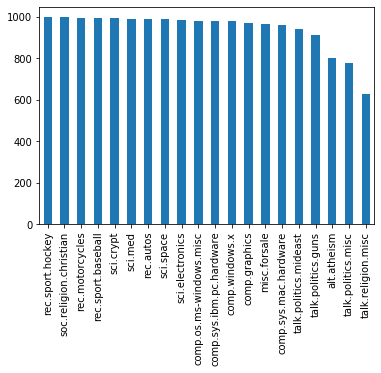

In [18]:
df_news.category.value_counts().plot(kind='bar')

### Analyse frequency distribution of entities

As a first step, we will plot the frequency distribution of our "bag-of-entities" and "bag-of-words" 

unique entities for max_depth 1: 13213
unique entities for max_depth 2: 15096
unique entities for max_depth 3: 15474
unique tokens: 186166


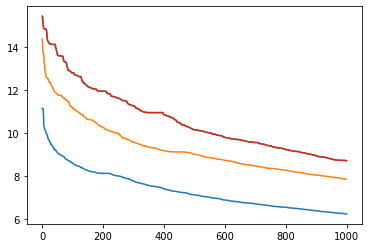

In [3]:
import seaborn as sns

def plot_frequency_distribution(frequencies,limit=10000):
    sns.lineplot(x=range(len(frequencies))[:limit],y=np.log(frequencies[:limit]))
    
def get_frequencies(elements):
    counter=Counter()
    counter.update(all_entities)
    
    frequencies=[]
    for e,f in counter.most_common(1000):
        frequencies.append(f)
    
    return frequencies

for depth in [1,2,3]:
    entity_extractor=LinkedEntityExtractor(max_depth=depth,categories_only=True)
    entities_by_text=entity_extractor(df_news.cleaned)
    
    all_entities=flatten(entities_by_text)
    print("unique entities for max_depth {}: {}".format(depth,len(set(all_entities))))
    plot_frequency_distribution(get_frequencies(all_entities))

token_extractor=TokenExtractor()
tokens_by_text=token_extractor(df_news.cleaned)
all_tokens= flatten(tokens_by_text)

plot_frequency_distribution(get_frequencies(all_tokens))

print("unique tokens: {}".format(len(set(all_tokens))))

From this plot, we can see that increasing values for <code>max_depth</code> leads to more highly frequent entities. This is observation is explained by the fact that several distinct entities share more and more "hierarchical ancestors" in the graph, the deeper we traverse the parents for each entity.

We can also find about 10 times more unique tokens than unique extracted categories. This is also an intuitive observation that can be explained by the fact that categories are more general [e.g. "banana", "orange", "apple", "apricot" belong to the same category "fruit"] and therefore one category-entity can describe multiple tokens in one. It must be also stressed that linked entities only reference the nouns in a document, while tokens include both nouns, verbs, adjectives. Therefore the discrepancy between unique elements of tokens vs entities is also affected by this

<h3>Topic classification using bag-of-entities</h3>

In [4]:
TOP_FEATURES=10000

results_linkedEntity=[]
for depth in [0,1,2]:
    for categories_only in [True,False]:
            
        if depth==0 and categories_only:
            continue 

        entity_extractor=LinkedEntityExtractor(max_depth=depth,categories_only=categories_only)
        vectorizer=CountVectorizer(tokenizer=identity,lowercase = False,max_df = 0.5,min_df = 10,max_features=TOP_FEATURES)

        classifier=NBEntityClassifier(entity_extractor,vectorizer)
        classifier.train(df_news_train.cleaned,df_news_train.category.tolist())

        train_score=classifier.score(df_news_train.cleaned,df_news_train.category.tolist())
        test_score=classifier.score(df_news_test.cleaned,df_news_test.category.tolist())

        results_linkedEntity.append({
            "depth":depth,
            "categories_only":categories_only,
            "train_score":train_score,
            "test_score":test_score
        })
        
df_linked_entities=pd.DataFrame(results_linkedEntity)
df_linked_entities["configuration"]='depth: ' + df_linked_entities["depth"].astype(str)+' categories_only: ' + df_linked_entities["categories_only"].astype(str)
df_linked_entities.to_csv('results/df_linked_entities.csv')

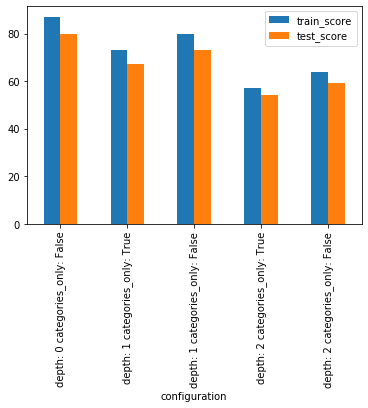

In [5]:
df_linked_entities.plot.bar(x="configuration",y=["train_score","test_score"])

<h4>Topic classification using bag of words</h4>

In [22]:
TOP_FEATURES=10000
results_tokenized=[]

token_extractor=TokenExtractor()
vectorizer=CountVectorizer(tokenizer=identity,lowercase = False,max_df = 0.5,min_df = 10,max_features=TOP_FEATURES)

classifier=NBEntityClassifier(token_extractor,vectorizer)
classifier.train(df_news_train.cleaned,df_news_train.category.tolist())

train_score=classifier.score(df_news_train.cleaned,df_news_train.category.tolist())
test_score=classifier.score(df_news_test.cleaned,df_news_test.category.tolist())

results_tokenized.append({
    "top_features":top_features,
    "train_score":train_score,
    "test_score":test_score
})
    
df_tokenized=pd.DataFrame(results_tokenized)
df_tokenized.to_csv('results/results_tokenized.csv',index=False)

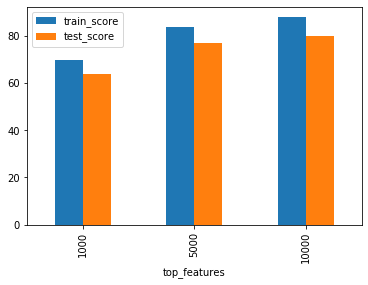

In [39]:
df_tokenized.plot.bar(x='top_features',y=['train_score','test_score'])

<h4>Topic Classification with varying dataset sizes </h4>

In [48]:
TOP_FEATURES=10000
results_split=[]

for split in [0.05,0.1,0.2,0.3,0.4,0.6,0.8]:
    np.random.seed(100)

    msk = np.random.rand(len(df_news)) < split
    df_train=df_news[msk]
    df_test=df_news[~msk]

    entity_extractor=LinkedEntityExtractor(max_depth=1,categories_only=False)
    token_extractor=TokenExtractor()
    
    vectorizer=CountVectorizer(tokenizer=identity,lowercase = False,max_df = 0.5,min_df = 10,max_features=TOP_FEATURES)
    
    classifier_entities=NBEntityClassifier(entity_extractor,vectorizer)
    classifier_entities.train(df_train.cleaned,df_train.category.tolist())

    train_score_entities=classifier_entities.score(df_train.cleaned,df_train.category.tolist())
    test_score_entities=classifier_entities.score(df_test.cleaned,df_test.category.tolist())
    
    classifier_tokens=NBEntityClassifier(token_extractor,vectorizer)
    classifier_tokens.train(df_train.cleaned,df_train.category.tolist())

    train_score_tokens=classifier_tokens.score(df_train.cleaned,df_train.category.tolist())
    test_score_tokens=classifier_tokens.score(df_test.cleaned,df_test.category.tolist())

    results_split.append({
        "split":split,
        "train_score_entities":train_score_entities,
        "test_score_entities":test_score_entities,
        "train_score_tokens":train_score_tokens,
        "test_score_tokens":test_score_tokens
    })

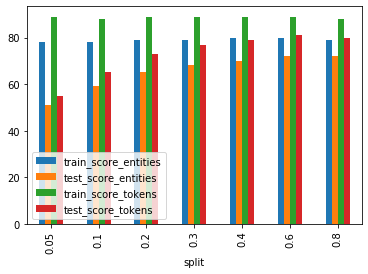

In [53]:
df_split=pd.DataFrame(results_split)
df_split.to_csv('results/results_split_entity.csv',index=False)

ax=df_split.plot.bar(x='split',y=['train_score_entities','test_score_entities','train_score_tokens','test_score_tokens'])
 
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='lower left')

### Tryout Section - Topic Classification

In [ ]:
#TAKE THE BEST MODEL AND RETRAIN IT
entity_extractor=LinkedEntityExtractor(max_depth=1,categories_only=False)
feature_selector=TopSelector(10000)

classifier=NBEntityClassifier(entity_extractor,feature_selector)
classifier.train(df_news_train.cleaned,df_news_train.category.tolist(),5000)

In [ ]:
input_text="""Here you can plug in your input text"""

print(classifier.predict([input_text]))[0]

# Corpus Topic Extraction

## Naive Topic Extraction using Categories

Categorizations such as "bananas are a type of fruit", "apples are a type of fruit", and "fruit is type of food", ...are very elementary generalizations. Given standard bag of words approaches, the grouping of "bananas", "apples", and "oranges" into one shared concept can only be done, when these terms frequently cooccur or reliably occur in the same textual contexts. With an ontology like wikidata, these conceptualizations are already given. Therefore we can naively treat every category as a topic and define every document as a distribution over these categories. With this approach, we can analyse the most important topics in each document by ranking all mentioned categories by frequency. Furthermore we can filter all documents that share the same topic (category), by finding those documents that include instances of a particular topic.

In [6]:
import spacy
from src.EntityLinker.EntityLinker import *
from src.EntityLinker.Utils import *
init_database_connection()
from collections import Counter

class LinkedCorpusAnalyser:
    
    def __init__(self,max_depth=1,categories_only=False):
        self.linkedEntityExtractor=LinkedEntityExtractor(max_depth,categories_only)
        
    def get_topics(self,documents):
        entities_by_text=self.linkedEntityExtractor(documents)
        
        all_entities=flatten(entities_by_text)
        
        counter=Counter(all_entities)
        
        return counter
    
    def print_topics(self,documents,limit=50):
        topics=self.get_topics(documents)
        
        for topic,frequency in topics.most_common(limit):
            print("Topic {0:<30} occured {1:<6} times (entity_id is {2:})".format(get_entity_name(topic)[:30].upper(),frequency,topic))
    
    def get_documents_for_category(self,documents,category):
        entities_by_text=self.linkedEntityExtractor(documents)
        
        filtered_documents=[]
        for document,entities in zip(documents,entities_by_text):
            if category in entities:
                filtered_documents.append(document)
        
        return filtered_documents
    
    def print_most_frequent_topics(max_depth=1,count=100):
        all_topics=self.get_topics()

List of top 20 "Topics" in the Newsgroup Corpus, sorted by frequency (<code>max_depth=1</code>)

In [11]:
corpus=LinkedCorpusAnalyser(max_depth=1,categories_only=True)
corpus.print_topics(df_news_test.cleaned,20)

Topic POLYPHYLETIC GROUP OF ORGANISM occured 11720  times (entity_id is 55983715)
Topic PERSON                         occured 11658  times (entity_id is 215627)
Topic NATURAL PERSON                 occured 11399  times (entity_id is 154954)
Topic OMNIVORE                       occured 11399  times (entity_id is 164509)
Topic HUMAN                          occured 10697  times (entity_id is 5)
Topic ABSTRACT OBJECT                occured 8145   times (entity_id is 7184903)
Topic CONCEPT                        occured 5578   times (entity_id is 151885)
Topic FILM                           occured 5572   times (entity_id is 11424)
Topic PRODUCT                        occured 5444   times (entity_id is 2424752)
Topic ORGANIZATION                   occured 5060   times (entity_id is 43229)
Topic VARIABLE-ORDER METACLASS       occured 5060   times (entity_id is 23958852)
Topic ACADEMIC DISCIPLINE            occured 4786   times (entity_id is 11862829)
Topic MENTAL REPRESENTATION          oc

List of top 20 "Topics" in the Newsgroup Corpus, sorted by frequency (<code>max_depth=2</code>)

In [18]:
corpus=LinkedCorpusAnalyser(max_depth=2,categories_only=True)
corpus.print_topics(df_news_test.cleaned,20)

Topic CONCEPT                        occured 174416 times (entity_id is 151885)
Topic ABSTRACT OBJECT                occured 117055 times (entity_id is 7184903)
Topic VARIABLE-ORDER METACLASS       occured 108328 times (entity_id is 23958852)
Topic MENTAL REPRESENTATION          occured 88039  times (entity_id is 2145290)
Topic ENTITY                         occured 67930  times (entity_id is 35120)
Topic ACADEMIC DISCIPLINE            occured 58219  times (entity_id is 11862829)
Topic CAPABILITY                     occured 53665  times (entity_id is 1347367)
Topic ORGANIZATION                   occured 50490  times (entity_id is 43229)
Topic PHYSICAL QUANTITY              occured 48182  times (entity_id is 107715)
Topic ACTIVITY                       occured 45888  times (entity_id is 1914636)
Topic GOODS                          occured 44723  times (entity_id is 28877)
Topic PRODUCT                        occured 44222  times (entity_id is 2424752)
Topic OCCURRENCE                  

### Find "topics" for a given document

In [20]:
nlp=get_entity_linker_pipeline()

In [21]:
#take random input text
document=df_news_test.cleaned.iloc[11]
print(document[:10000])

Marc Thibault (marctanda.isis.org) writes: (The Jester) writes: Proof Windows is a Virus:It is very widespread, It eats up your disk space, It slows down your computer, It takes control over your computer, It performs disk access at random times, It displays silly messages on your screen, It randomly crashes the computerVesselin This sounds like a version Unix. Solaris? as someone who just lived through a switch from SunOS4.x.x. to Solaris, i'll heartily agree with this. ObCrypt: one of my main gripes with Solaris is its braindead mailx, which is almost enough like mail to get you hoping, but crashes horribly when you try to do anything useful with it. (like use pgp capable sendmail replacements.) jason "I stood up on my van. I yelled, `Excuse me, sir. Ain't nothing wrong with this country that a few plastic explosives won't cure!'" Steve Taylor, I Blew Up the Clinic Real Good `,`,`,`,`,`,`,`,`,`,`,`,`,`,`,`,`,` steinerjupiter.cse.utoledo.edu `,`,`,`


In [23]:
#nlp(document)._.linkedEntities.pretty_print()
nlp(document)._.linkedEntities.print_categories(max_depth=2,limit=20)

operating system (10) : Microsoft Windows,Unix,Unix,Solaris,Solaris,Solaris,Solaris,Solaris,Solaris,Pretty Good Privacy
computing platform (8) : Microsoft Windows,computer,computer,Unix,Solaris,Solaris,Solaris,Pretty Good Privacy
proprietary software (7) : Microsoft Windows,Unix,Solaris,Solaris,Solaris,Pretty Good Privacy,Pretty Good Privacy
system software (6) : Microsoft Windows,Unix,Solaris,Solaris,Solaris,Pretty Good Privacy
software (6) : Microsoft Windows,Unix,Solaris,Solaris,Solaris,Pretty Good Privacy
human (5) : Franz Marc,The Jester,The Jester,Steve Taylor,Steve Taylor
literary work (4) : letter,Someone,Someone,letter
Unix-like operating system (4) : Unix,Solaris,Solaris,Solaris
polyphyletic group of organisms known by one particular common name (3) : Franz Marc,The Jester,Steve Taylor
natural person (3) : Franz Marc,The Jester,Steve Taylor
omnivore (3) : Franz Marc,The Jester,Steve Taylor
person (3) : Franz Marc,The Jester,Steve Taylor
film (3) : Virus,Anything,Anything
seri

### Finding documents by "topic":

Next, we will list all documents that contain a particular topic (category)

In [83]:
topics={
    "countries":6256,
    "dynamic programming languages":1268980,
    "programming languages": 9143,
    "religions":9174,
    "cars":17412622
}

topic="religions"


documents=corpus.get_documents_for_category(df_news_test.cleaned,topics[topic]) #programming language

print("{} documents found for topic {}".format(len(documents),topic))
print()
print("first document is {}".format(documents[0][:1000]))

94 documents found for topic religions

first document is In article <30957@galaxy.ucr.edu raffi@watnxt08.ucr.edu (Raffi R Kojian) writes: I would just like to say that I hope everybody knows that everything Serdar has said are lies. Coming from an idiot/crook Armenian, I'd take that as a compliment. Your criminal grandparents committed unheard-of crimes, resorted to all conceivable methods of despotism, organized massacres, poured petrol over babies and burned them, raped women and girls in front of their parents who were bound hand and foot, took girls from their mothers and fathers and appropriated personal property and real estate. And today, they put Azeris in the most unbearable conditions any other nation had ever known in history. Source: John Dewey: "The New Republic," Vol. 40, Nov. 12, 1928, pp. 268-9. "They [Armenians] traitorously turned Turkish cities over to the Russian invader; that they boasted of having raised an army of one hundred and fifty thousand men to fight a ci

<h3>Problems with this approach:</h3>

From observing category on a per-document basis, we can conclude that ranking categories by frequency does not give meaningful results. Certain categories occur throughout many documents but carry no particular value for determining the topic of the document (e.g. category "Person", or "Second order metaclass"). On the other hand, relevant categories in a document can occur few times but only infrequent in the whole corpus. In order to present meaningful topics, we must take this distribution of term frequencies into account.
One popular approach for ranking terms in documents by relevance is TfIdf (Term-Frequency-Inverse-Document-Frequency). It weighs the importance of a term by how often it occurs in the given document in relation to how often it occurs across all documents of a corpus. Frequent occurence of a term in a given document in combination with infrequent occurence across a corpus results in a high relevance score. In contrast, the relevance of a term is discounted if it occurs frequently in all documents. 
By applying this method to our "bags-of-entities", the frequent categories ("people","second order metaclass") should be discounted.

Furthermore grouping documents by categories does not seem useful in practice. First, there are too many possible categories by which documents can be grouped. In particular, categories from the wikidata graph tend to be very fine grained due to their encyclopedi origin. Second, this method is not useful if we have no information about the distribution of categories across the documents. And finally the occurence of instances from a single category is no meaningul indicator for the topic of a document. Only combinations of multiple categories will be able to describe a meaningful topic in practice. For that, we need to look at more sophisticated approaches.

## Topic Clustering using Tfidf + KMeans

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

def identity(el):
    return el

tfidf=TfidfVectorizer(tokenizer=identity,max_df=1.0,min_df=1,max_features=10000,lowercase=False)
kmeans =  MiniBatchKMeans(n_clusters=20,random_state=0,batch_size=4000)

In [122]:
def get_top_keywords(data, clusters, labels, n_terms,translate_entities=False):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        if translate_entities:
            print(','.join([get_entity_name(labels[t]) for t in np.argsort(r)[-n_terms:]]))
        else:
            print(','.join([str(labels[t]) for t in np.argsort(r)[-n_terms:]]))

Print top keywords for topic clusters using bag-of-entities (<code>max_depth=1</code>,<code>categories_only</code>)

In [123]:
linked_entity_extractor=LinkedEntityExtractor(max_depth=1,categories_only=True)
linked_entities=linked_entity_extractor(df_news.cleaned)

transformed=tfidf.fit_transform(linked_entities)
clusters=kmeans.fit_predict(transformed)

get_top_keywords(transformed, clusters, tfidf.get_feature_names(), n_terms=10,translate_entities=True)

print("----------------------------------------")

done

Cluster 0
visual artwork,concept,series,human,film,omnivore,natural person,person,polyphyletic group of organisms known by one particular common name,abstract object

Cluster 1
IP network,organization,website,interactive media,online publication,digital media,network,computer network,technical system,telecommunications network

Cluster 2
type of sport,human,natural person,omnivore,polyphyletic group of organisms known by one particular common name,person,baseball team,entertainment,play,recreative work

Cluster 3
moving image,audiovisual work,visual artwork,series,film,human,natural person,omnivore,polyphyletic group of organisms known by one particular common name,person

Cluster 4
omnivore,polyphyletic group of organisms known by one particular common name,person,publication,literary work,communication medium,written work,document,text,information resource

Cluster 5
person,ethnic group,group of humans,social group,construct,political concept,nation,people,ethnoreligious group,

We can observe a number of logically meaningful cluster such as:

<b>Cluster 1:</b> <code>IP network,organization,website,interactive media,online publication,digital media,network,computer network,technical system,telecommunications network</code>

<b>Cluster 14:</b> <code>economic unit,business,organization,product,electronic machine,driver,proprietary software,operating system,computing platform,system software</code>

<b>Cluster 6:</b> <code>abstract object,handle,emulator,terminal client,free and open-source software,terminal emulator,software library,software component,programming tool,software category</code>

But also highly abstract clusters:
<b>Cluster 11:</b> <code>centered icosahedral number,5th power,star number,stella octangula number,square triangular number,centered dodecahedral number,unit,seventh power,multiplicative identity,fourth power</code>

Next, we compare the cluster centers for the bag-of-words model

In [143]:
token_extractor=TokenExtractor()

tokenized_documents=token_extractor(df_news.cleaned)
transformed=tfidf.fit_transform(tokenized_documents)
clusters=kmeans.fit_predict(transformed)

get_top_keywords(transformed, clusters, tfidf.get_feature_names(), n_terms=10)

print("----------------------------------------")


Cluster 0
peace,write,people,kill,Jewish,Palestinian,Jew,Arab,Israeli,Israel

Cluster 1
NT,window,mouse,OS/2,run,version,card,DOS,driver,Windows

Cluster 2
problem,write,need,like,monitor,know,system,card,work,use

Cluster 3
medical,article,cause,treatment,food,disease,patient,MSG,drug,doctor

Cluster 4
use,display,problem,program,run,application,server,font,X,window

Cluster 5
people,go,time,post,say,like,know,think,article,write

Cluster 6
Internet,Michael,peace,know,Thanks,article,$,write,M,+

Cluster 7
sin,write,think,Bible,Christ,people,believe,Jesus,Christian,God

Cluster 8
night,team,playoff,win,baseball,score,hockey,play,ESPN,game

Cluster 9
write,find,Thanks,know,convert,Windows,directory,program,format,file

Cluster 10
state,Muslim,article,think,government,write,weapon,people,law,right

Cluster 11
good,science,theory,find,article,know,help,write,read,book

Cluster 12
Asking,new,condition,include,offer,sale,price,ship,sell,$

Cluster 13
GIF,bite,file,screen,TIFF,color,program

<b>Cluster 0:</b> <code>peace,write,people,kill,Jewish,Palestinian,Jew,Arab,Israeli,Israel</code>

<b>Cluster 13:</b> <code>GIF,bite,file,screen,TIFF,color,program,format,display,image</code>

<b>Cluster 1:</b> <code>NT,window,mouse,OS/2,run,version,card,DOS,driver,Windows</code>


### Conclusion

The most notable qualitative difference between the two clusterings from bag-of-words and bag-of-entities is that bag-of-entities returns clusters that are fall into the same logical domain (e.g. medication,chemical component,chemical compound) whereas bag-of-words returns words that have high associativity (e.g. people,Palestinian,kill,Turkish,Muslim)

# LDA

For the sake of completeness, I will show how LDA can be done withs bags-of-entities. The following example will use <code>pyldavis</code> to visualize LDA clusters. It will give a comparison of running LDA on bag-of-words vs. bag-of-entities and evaluate the results by subjective comparison.

In [145]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

init_database_connection()

In [146]:
def visualize_lda(elements_by_document,clusters=20):
    
    def identity(element):
        return element
    
    tf_vectorizer = CountVectorizer(tokenizer=identity,
                                lowercase = False,
                                max_df = 0.5, 
                                min_df = 10)
    
    
    dtm_tf = tf_vectorizer.fit_transform(elements_by_document)
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
    dtm_tfidf = tfidf_vectorizer.fit_transform(elements_by_document)
    # for TF DTM
    lda_tf = LatentDirichletAllocation(n_components=clusters, random_state=0)
    lda_tf.fit(dtm_tf)
    # for TFIDF DTM
    lda_tfidf = LatentDirichletAllocation(n_components=clusters, random_state=0)
    lda_tfidf.fit(dtm_tfidf)
    return pyLDAvis.sklearn.prepare(lda_tf,dtm_tf,tf_vectorizer)

### LDA for linked entities (<code>max_depth=1</code>, <code>categories_only=True</code>)

In [148]:
linked_entities_translated=[]
for entities in linked_entities:
    linked_entities_translated.append([get_entity_name(entity) for entity in entities])

visualize_lda(linked_entities_translated)

/home/emanuel/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.051884  0.251319       1        1  7.597369
7      0.090688 -0.073222       2        1  7.319438
3      0.018402  0.055162       3        1  6.720048
10     0.164469 -0.048127       4        1  6.306221
19     0.185837  0.003133       5        1  5.918851
6      0.106505  0.053629       6        1  5.831490
12    -0.214588 -0.041164       7        1  5.698634
13    -0.190844 -0.086805       8        1  5.628808
8     -0.008042 -0.076376       9        1  5.550153
9      0.166791 -0.012695      10        1  5.436559
2     -0.138755 -0.119519      11        1  5.208900
0      0.085921 -0.048579      12        1  4.964870
4      0.039782  0.003500      13        1  4.680828
14    -0.098038  0.106967      14        1  4.351400
18     0.012234 -0.097126      15        1  4.120656
1      0.153692  0.016330      16        1  4.018798
11    -0.081007  0.294514      17        1  2.905072
15    -0.124545 -0.132986      18        1  2.894286
17    -0.027215 -0.064099      19        1  2.434499
16    -0.089401  0.016143      20        1  2.413119, topic_info=                         Term          Freq         Total Category  logprob  \
4101                  product  34132.000000  34132.000000  Default  30.0000   
622   archaeological artifact   9988.000000   9988.000000  Default  29.0000   
4739             social group  16217.000000  16217.000000  Default  28.0000   
3706             organization  26950.000000  26950.000000  Default  27.0000   
2353                    goods  12400.000000  12400.000000  Default  26.0000   
...                       ...           ...           ...      ...      ...   
3434            musical group    772.653218   8381.744334  Topic20  -4.4958   
3431         musical ensemble    743.355803  10439.837353  Topic20  -4.5345   
400       academic discipline    661.236050  24421.006143  Topic20  -4.6516   
4704                   single    589.144048   7137.765535  Topic20  -4.7670   
512                     album    577.163128  10228.269113  Topic20  -4.7875   

      loglift  
4101  30.0000  
622   29.0000  
4739  28.0000  
3706  27.0000  
2353  26.0000  
...       ...  
3434   1.3403  
3431   1.0820  
400    0.1152  
4704   1.2298  
512    0.8495  

[1431 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0        11  0.004221  0 number class
0        14  0.022510  0 number class
0        20  0.972144  0 number class
4         1  0.998191       5th power
4        10  0.000302       5th power
...     ...       ...             ...
5611      6  0.952681      xenobiotic
5611     16  0.043578      xenobiotic
5611     17  0.001854      xenobiotic
5619     18  0.961790      zonohedron
5622      5  0.989353           şəhər

[7755 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 4, 11, 20, 7, 13, 14, 9, 10, 3, 1, 5, 15, 19, 2, 12, 16, 18, 17])

### LDA for tokenized documents

In [151]:
visualize_lda(tokens)

/home/emanuel/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.134699 -0.012594       1        1  11.033569
7     -0.076199  0.174305       2        1   9.543018
13     0.113903 -0.032928       3        1   8.980558
17     0.128884 -0.050353       4        1   6.996452
2      0.069245 -0.109748       5        1   6.643455
16     0.168141 -0.071107       6        1   6.548218
9      0.089869 -0.000207       7        1   5.419724
0      0.105151 -0.045398       8        1   5.096045
3     -0.227427  0.049742       9        1   4.829970
19     0.011855  0.077564      10        1   4.663748
1      0.037284  0.071560      11        1   4.577159
8     -0.022103  0.041006      12        1   4.398574
15    -0.102428  0.174454      13        1   3.965625
5      0.098638  0.021210      14        1   3.538344
18     0.036962  0.031209      15        1   3.277331
10     0.033516  0.035994      16        1   3.081523
11     0.010462 -0.058720      17        1   2.368798
14    -0.345306 -0.141510      18        1   2.037719
12    -0.125687  0.132285      19        1   1.550818
6     -0.139459 -0.286762      20        1   1.449353, topic_info=                                                Term          Freq  \
5                                                  +  10476.000000   
3                                                  $   8314.000000   
6848                                               `   5943.000000   
6712                                               X   5835.000000   
3773   MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX   3259.000000   
...                                              ...           ...   
14083                                          shall     60.307885   
11660                                            man     64.374061   
15433                                            use     67.273822   
6354                                      University     58.232096   
11395                                            law     57.109379   

              Total Category  logprob  loglift  
5      10476.000000  Default  30.0000  30.0000  
3       8314.000000  Default  29.0000  29.0000  
6848    5943.000000  Default  28.0000  28.0000  
6712    5835.000000  Default  27.0000  27.0000  
3773    3259.000000  Default  26.0000  26.0000  
...             ...      ...      ...      ...  
14083    703.080899  Topic20  -6.1455   1.7780  
11660   2379.302140  Topic20  -6.0803   0.6242  
15433   7017.042730  Topic20  -6.0362  -0.4133  
6354    2307.574184  Topic20  -6.1805   0.5545  
11395   2273.144195  Topic20  -6.2000   0.5501  

[1606 rows x 6 columns], token_table=       Topic      Freq                                               Term
term                                                                     
2         19  0.955485                                               "(gd
3          2  0.022130                                                  $
3          3  0.004691                                                  $
3          5  0.000120                                                  $
3          6  0.000120                                                  $
...      ...       ...                                                ...
15904     13  0.003497                                                  ~
15904     17  0.003497                                                  ~
15904     18  0.916171                                                  ~
15904     19  0.069937                                                  ~
15913     10  0.959069  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~...

[7099 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 14, 18, 3, 17, 10, 1, 4, 20, 2, 9, 16, 6, 19, 11, 12, 15, 13, 7])

# Conclusion 

* The wikidata knowledge graph contains a lot of different categories across all domains
* Wikidata taxonomy is not always reflecting the inuitive conceptualization of the world
* Entity Linking is difficult, especially for texts that have no encyclopedic source
* Classifications that is based on extracted entities only shows roughly the same performance as corresponding the bag-of-words approach
* Adding categories of entites to classification achieves reasonable performance, but is not improving classification scores
* Wikidata graph is distorted towards encyclopedic items
* Extracting categories from documents is not helpful for describing the document content
* Topic clusters with bag-of-entities are logically meaningful but often very abstract and hard to interpret

## Outlook

* Need to improve entity linking for non-encyclopedic texts
* Combine features from bag-of-entities and bag-of-words 
* Limit the knowledge graph to entities and categories that should be considered topics, remove elements that are too abstract and have no practical use for topic detection

## References

https://www.kaggle.com/kenshoresearch/kensho-derived-wikimedia-data

https://www.kaggle.com/kenshoresearch/kdwd-wikipedia-introduction

https://www.kaggle.com/kenshoresearch/kdwd-aliases-and-disambiguation

https://github.com/gokriznastic/20-newsgroups_text-classification

https://wikiworkshop.org/2019/papers/Wiki_Workshop_2019_paper_1.pdf

https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb#topic=3&lambda=1&term=